# Book stock project

In this project we...


In [167]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import os
import seaborn as sns
from time import sleep
from tqdm import tqdm

## Data

In [168]:

books = pd.read_csv('./data/books.csv')

books.head()


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [169]:
# Check data types
books.dtypes
# Convert publication year to datetime
books['original_publication_year'] = pd.to_datetime(books['original_publication_year'], format='%Y', errors='coerce').dt.year

# since the last complete book year of this dataset is 2016 we cutoff books after 2016
books = books[books['original_publication_year'] <= 2016]

books.dtypes

book_id                        int64
goodreads_book_id              int64
best_book_id                   int64
work_id                        int64
books_count                    int64
isbn                          object
isbn13                       float64
authors                       object
original_publication_year    float64
original_title                object
title                         object
language_code                 object
average_rating               float64
ratings_count                  int64
work_ratings_count             int64
work_text_reviews_count        int64
ratings_1                      int64
ratings_2                      int64
ratings_3                      int64
ratings_4                      int64
ratings_5                      int64
image_url                     object
small_image_url               object
dtype: object

### Data scraping

Using each book id, we scrape the most popular reviews from goodreads.com


In [170]:
# check if file exists
if os.path.exists('./data/most_popular_reviews.csv'):
    # load file skips first 5 lines of metadata and last 1 line of footer
    most_popular_reviews = pd.read_csv('./data/most_popular_reviews.csv', skiprows=0, skipfooter=0)
else:
    #run scraping scripts
    books = pd.read_csv('./data/books.csv')

    most_popular_reviews = pd.DataFrame(columns=["goodreads_book_id", "score","date","review_text"])

    for index, row in tqdm(books.iterrows(), total=books.shape[0]):
        sleep(1)  # sleep for 1 second to avoid rate limiting
        goodreads_book_id = row['goodreads_book_id']
        url = f'https://www.goodreads.com/book/show/{goodreads_book_id}'
        
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            # fetch elements with class "ReviewCard"
            review_cards = soup.find_all(class_='ReviewCard')
            for review in review_cards:
                try:
                    #seperate review text from class "ReviewText"
                    review_text = review.find(class_='ReviewText')
                    review_text = review_text.get_text(strip=True)
                    #clean review text by removing newline characters and line separators
                    review_text = review_text.replace('\n', ' ').replace('\r', ' ')

                    #fetch date from class "Text Text__body3"
            
                    date_elem = review.find(class_='Text Text__body3')
                    date = date_elem.get_text(strip=True).lower().replace(',', '')
                    month, day, year = date.split(' ')
                    # Get review score from class "RatingStars RatingStars__small"
                    # take the aria-label attribute, which is a string formmated as "Rating x out of 5"
                    rating_stars = review.find(class_='RatingStars RatingStars__small')
                    rating = rating_stars['aria-label']
                    rating = rating.split(' ')[1]  # extract the number part

                    most_popular_reviews.loc[len(most_popular_reviews)] ={
                        "goodreads_book_id": goodreads_book_id,
                        "score": rating,
                        "date": f"{month}/{day}/{year}",
                        "review_text": review_text
                    }
                except Exception as e:
                    print("Error parsing review:", e)
        if index % 1000 == 0:
            #save progress every 1000 books, just in case of interruption
            most_popular_reviews.to_csv('./data/most_popular_reviews'+str(index)+'.csv', index=False)
    #save final dataframe
    most_popular_reviews.to_csv('./data/most_popular_reviews.csv', index=False)
most_popular_reviews.head()

,goodreads_book_id,score,date,review_text
0,2767052,4,april/25/2023,Suzanne Collins hasballsovaries of steelto mak...
1,2767052,5,august/1/2023,Dystopian Perfection.In a post-apocalyptic fut...
2,2767052,5,december/4/2013,"LMAAAOOOO! Thats Peeta folks! xDHahahahaha,Tot..."
3,2767052,4,december/2/2025,“Happy Hunger Games! And may the odds be ever ...
4,2767052,5,november/24/2015,I was forced into watching Mockingjay: Part II...


In [171]:
print(most_popular_reviews.dtypes)
#convert data column to datetime
most_popular_reviews['date'] = pd.to_datetime(most_popular_reviews['date'])
print(most_popular_reviews.dtypes)

goodreads_book_id     int64
score                 int64
date                 object
review_text          object
dtype: object


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_30708\3756228911.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  most_popular_reviews['date'] = pd.to_datetime(most_popular_reviews['date'])


goodreads_book_id             int64
score                         int64
date                 datetime64[ns]
review_text                  object
dtype: object


In [172]:
most_popular_reviews

,goodreads_book_id,score,date,review_text
0,2767052,4,2023-04-25,Suzanne Collins hasballsovaries of steelto mak...
1,2767052,5,2023-08-01,Dystopian Perfection.In a post-apocalyptic fut...
2,2767052,5,2013-12-04,"LMAAAOOOO! Thats Peeta folks! xDHahahahaha,Tot..."
3,2767052,4,2025-12-02,“Happy Hunger Games! And may the odds be ever ...
4,2767052,5,2015-11-24,I was forced into watching Mockingjay: Part II...
...,...,...,...,...
292386,8914,3,2023-10-07,"Certainly good overview, but lacks synthesis. ..."
292387,8914,4,2022-12-02,Excellent history
292388,8914,4,2008-06-14,A solid effort. Keegan does a pretty good job ...
292389,8914,4,2015-02-06,There are not many books out there about the F...


In [173]:
def recency_score(date, current_date):
    days_since_review = (current_date - date).days
    if days_since_review < 30:
        return 6 # Future date, invalid
    if days_since_review <= 90:
        return 5
    elif days_since_review <= 180:
        return 4
    elif days_since_review <= 365:
        return 3
    elif days_since_review <= 365*5:
        return 2
    else:
        return 1
    
# current date is latest date in the dataset

#current_date = most_popular_reviews['date'].max()
#current_date = datetime.datetime(int(books['original_publication_year'].max()), 12, 31)
current_date = datetime.datetime(2025, 12, 1)

most_popular_reviews['recency_score'] = most_popular_reviews['date'].apply(lambda x: recency_score(x, current_date))



In [174]:
# average recency score per book and merge with books dataframe
recency_scores = most_popular_reviews.groupby('goodreads_book_id')['recency_score'].mean().reset_index()
recency_scores.rename(columns={'recency_score': 'avg_recency_score'}, inplace=True)
books = books.merge(recency_scores, on='goodreads_book_id', how='left')

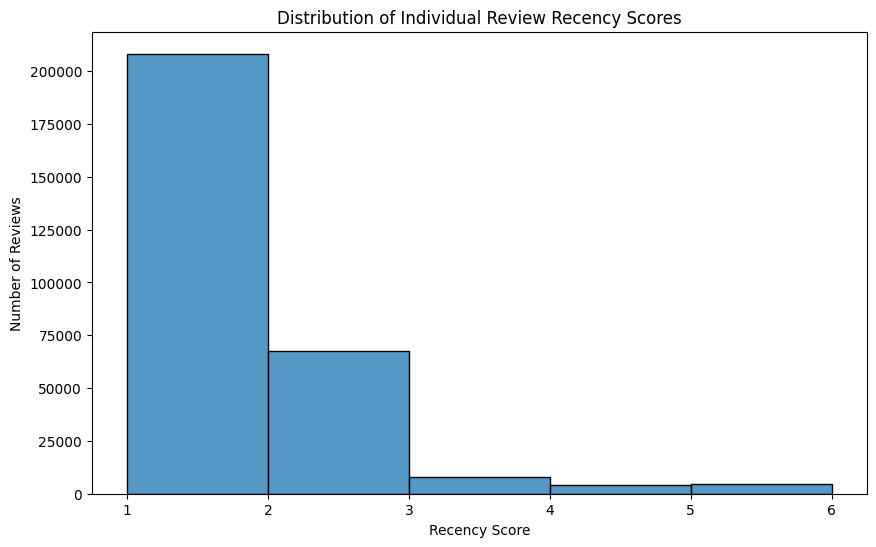

In [179]:
#plot distributions of individual recency scores
plt.figure(figsize=(10,6))
sns.histplot(most_popular_reviews['recency_score'], bins=5, kde=False)
plt.title('Distribution of Individual Review Recency Scores')
plt.xlabel('Recency Score')
plt.ylabel('Number of Reviews')
plt.show()

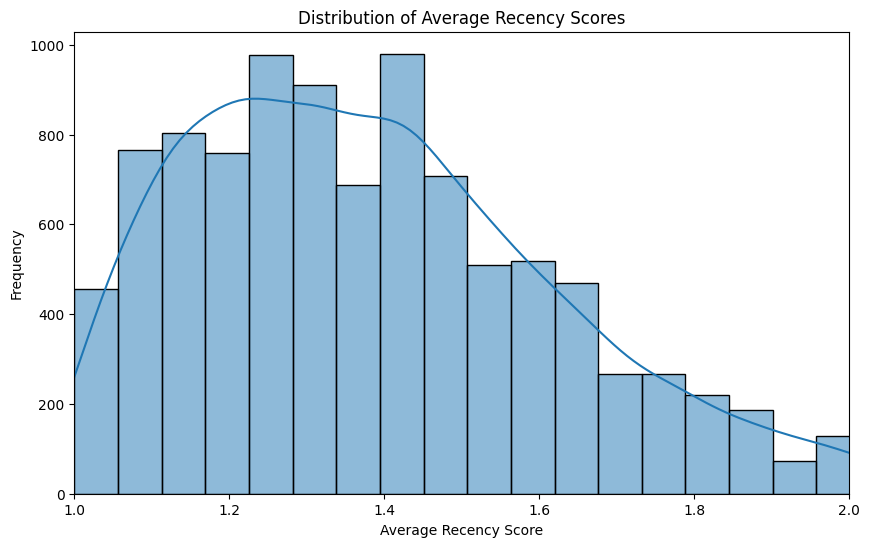

In [175]:
# plot distribution of recency scores, only show score between 1 and 2
plt.figure(figsize=(10,6))
sns.histplot(books['avg_recency_score'].dropna(), bins=30, kde=True)
# limit x axis to 1 to 2
plt.xlim(1, 2)
plt.title('Distribution of Average Recency Scores')
plt.xlabel('Average Recency Score')
plt.ylabel('Frequency')
plt.show()

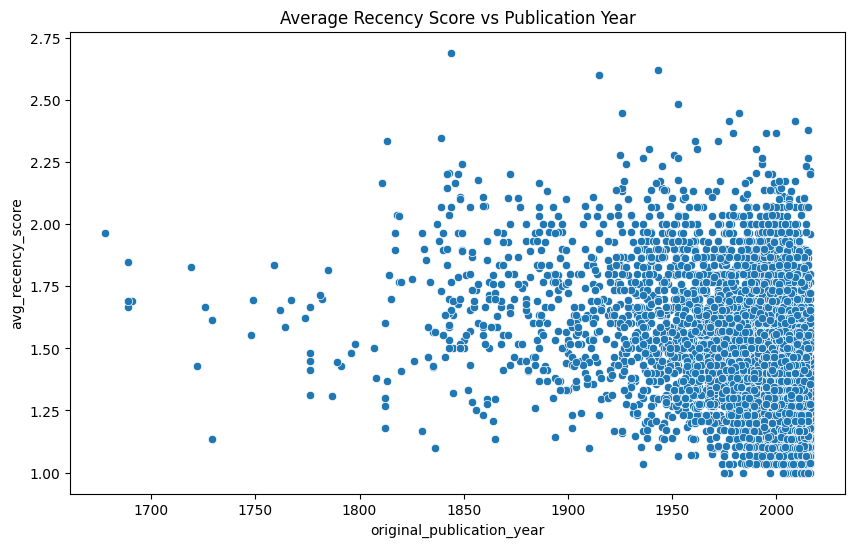

In [176]:
#plot recency score against data of publication
plt.figure(figsize=(10,6))
sns.scatterplot(data=books, x='original_publication_year', y='avg_recency_score')
plt.title('Average Recency Score vs Publication Year')
plt.show()

We have to keep in mind that the reviews scraped are from current times. If we had acces to a dataset with current year books we would probaly see a stronger correlation with recency score. Since by todays reviews these books are all 9 to 25 years old the correlation probaly fades, as recent reviews tends towards being more periodic, unless of course the book became popular again, where the assumption would be an influx of recent reviews spiking the score indicating a more popular book.

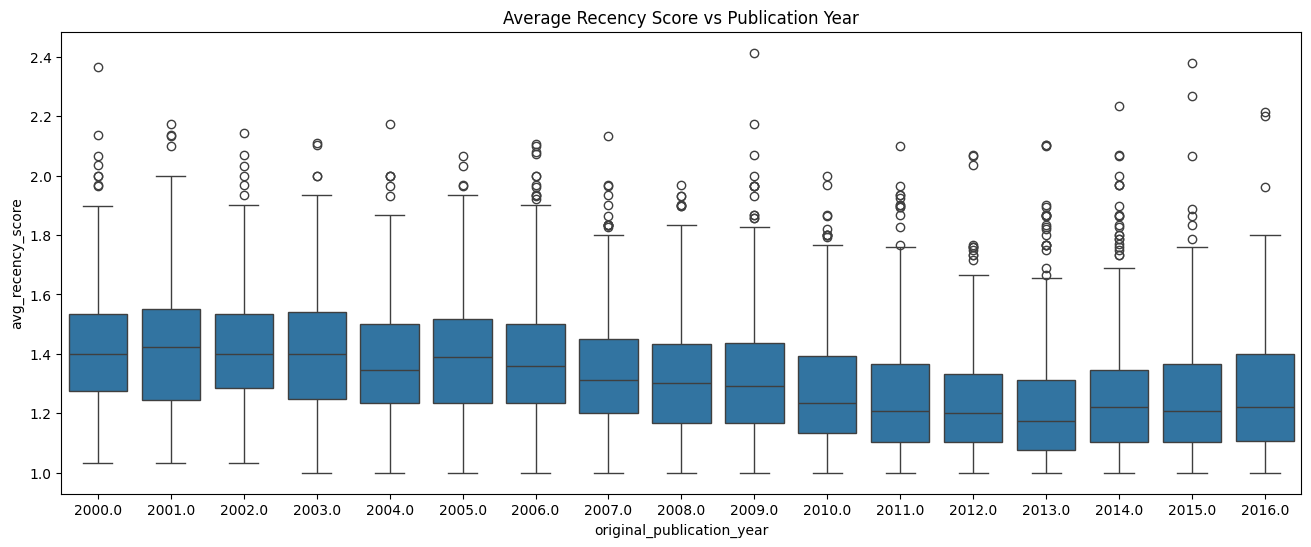

In [177]:
#plot recency score against data of publication

plt.figure(figsize=(16,6))
#only books from 2000 onwards
books_2000 = books[books['original_publication_year'] >= 2000]
#histograms of avg recency score for books from 2000 onwards

sns.boxplot(data=books_2000, x='original_publication_year', y='avg_recency_score')

plt.title('Average Recency Score vs Publication Year')
plt.show()

In [180]:
# top most recent reviewed books in terms of recency score
top_recent_reviews = books.sort_values(by='avg_recency_score', ascending=False).head(20)
top_recent_reviews[["goodreads_book_id","original_title", "avg_recency_score", "original_publication_year"]]

,goodreads_book_id,original_title,avg_recency_score,original_publication_year
8251,1990,The Life and Adventures of Martin Chuzzlewit,2.689655,1844.0
4869,220826,Kürk Mantolu Madonna,2.620690,1943.0
2974,7723,Die Verwandlung und andere Erzählungen,2.600000,1915.0
208,485894,Die Verwandlung,2.600000,1915.0
4126,327246,Művészeti Anatómia,2.482759,1953.0
6420,95693,The Blue Castle,2.448276,1926.0
1762,11607,The Running Man,2.448276,1982.0
5079,6952423,I Am Ozzy,2.413793,2009.0
70,11588,The Shining,2.413793,1977.0
1310,18966819,Golden Son,2.379310,2015.0


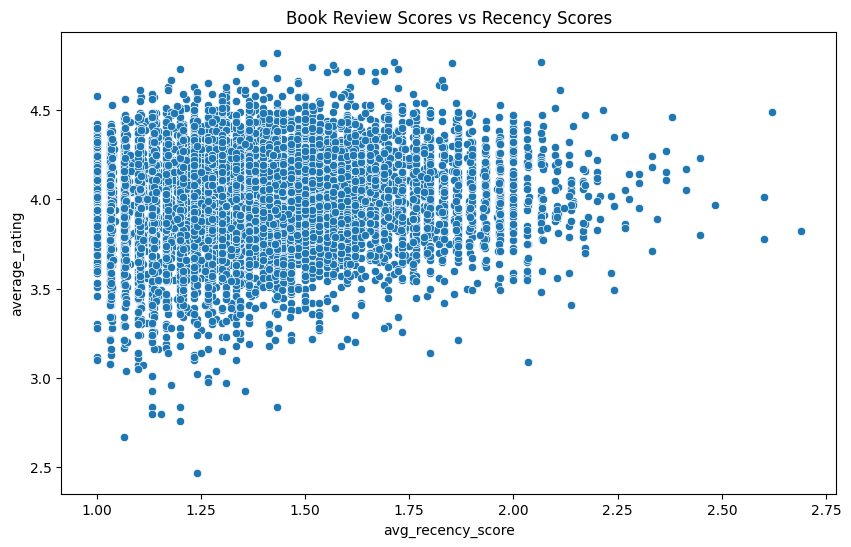

In [181]:
# plots book review scores against recency scores
plt.figure(figsize=(10,6))
sns.scatterplot(data=books, x='avg_recency_score', y='average_rating')
plt.title('Book Review Scores vs Recency Scores')
plt.show()